Import des librairies nécessaires

In [9]:
from enum import Enum

import cv2 as cv
import matplotlib.pyplot as plt
from numpy import ndarray


Variables globales

In [10]:
PICTURE_SIZE_SHEET_DETECTION = 1000

Positions des visuels sur le plastron

In [11]:
class Zone(Enum):
    TOP_LEFT = 1
    TOP_RIGHT = 2
    BOTTOM_LEFT = 3
    BOTTOM_RIGHT = 4
    CENTER = 5

Extraction d'un visuel du plastron

In [12]:
def get_crop_coordinates(image: ndarray, target_zone: Zone):
    width, height, _ = image.shape
    x1, x2, y1, y2 = 0, width, 0, height

    if target_zone in [Zone.TOP_RIGHT, Zone.BOTTOM_RIGHT]:
        x1 = int(width / 2)
    if target_zone in [Zone.BOTTOM_LEFT, Zone.BOTTOM_RIGHT]:
        y1 = int(height / 2)
    if target_zone in [Zone.TOP_LEFT, Zone.BOTTOM_LEFT]:
        x2 = int(width / 2)
    if target_zone in [Zone.TOP_LEFT, Zone.TOP_RIGHT]:
        y2 = int(height / 2)
    if target_zone == Zone.CENTER:
        x1, y1 = int(width / 4), int(height / 4)
        x2, y2 = width - x1, height - y1

    return {'x1': x1, 'x2': x2, 'y1': y1, 'y2': y2}
        


def get_target_picture(sheet_mat: ndarray, target_zone: Zone):
    sheet_mat_clone = sheet_mat.copy()
    coordinates = get_crop_coordinates(sheet_mat_clone, target_zone)
    return sheet_mat_clone[coordinates['x1']:coordinates['x2'], coordinates['y1']:coordinates['y2']]


Test de l'extraction des visuels

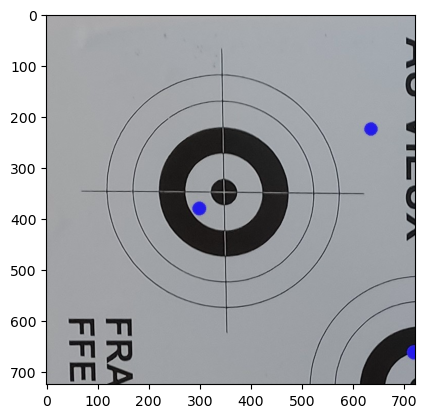

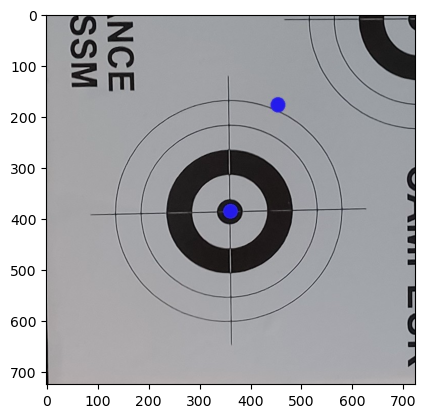

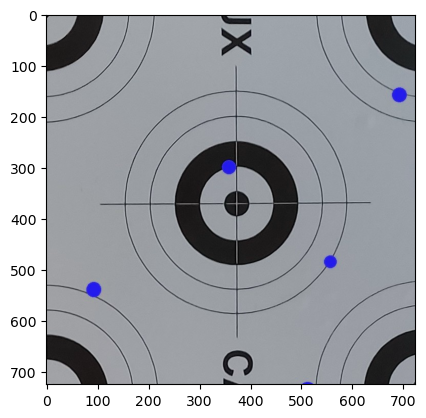

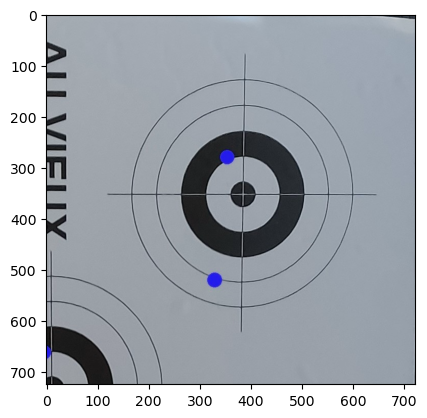

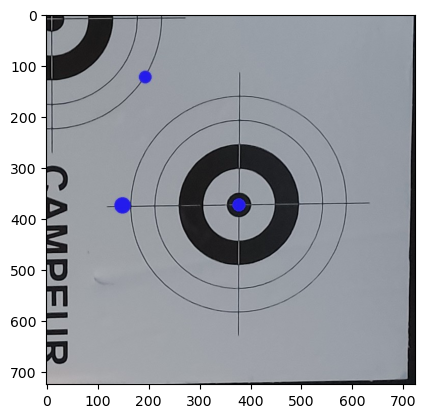

In [13]:
image = cv.imread('images/cropped_sheet.jpg')
zones = [Zone.TOP_LEFT, Zone.TOP_RIGHT,Zone.CENTER, Zone.BOTTOM_LEFT, Zone.BOTTOM_RIGHT]
for zone in zones:
    sheet_mat = get_target_picture(image, zone)
    plt.imshow(sheet_mat)
    plt.show()



Récupération des coordonnées du plastron sur une image

In [14]:
def enhance_image(image:ndarray, blur_radius:int = 0):
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    h, saturation, v = cv.split(hsv)
    if blur_radius > 0:
        saturation = cv.blur(saturation, (blur_radius, blur_radius))
    return saturation


def get_edges(image:ndarray,blur_radius:int = 0, canny_threshold_1:int = 100, canny_threshold_2:int = 200):
    image_clone = image.copy()
    if blur_radius > 0:
        image_clone = cv.blur(image_clone, (blur_radius, blur_radius))
    return cv.Canny(image_clone, canny_threshold_1, canny_threshold_2)

def get_biggest_valid_contour(contours, min_area:int = 1000):
    biggest_contour = None
    biggest_area = 0
    for contour in contours:
        approx_distance = cv.arcLength(contour, True) * 0.01;
        approx = cv.approxPolyDP(contour, approx_distance, True)
        valid = True
        if len(approx) != 4 or cv.contourArea(approx) < biggest_area:
            valid = False
        else:
            angles = []
            for i in range(4):
                p1 = approx[i][0]
                p2 = approx[(i + 1) % 4][0]
                p3 = approx[(i + 2) % 4][0]
                v1 = (p1[0] - p2[0], p1[1] - p2[1])
                v2 = (p3[0] - p2[0], p3[1] - p2[1])
                dot_product = v1[0] * v2[0] + v1[1] * v2[1]
                norm_v1 = (v1[0] ** 2 + v1[1] ** 2) ** 0.5
                norm_v2 = (v2[0] ** 2 + v2[1] ** 2) ** 0.5
                angle = dot_product / (norm_v1 * norm_v2)
                angles.append(angle)
            for angle in angles:
                if angle < 1.22173 or angle > 1.91986:
                    valid = False
                    break
            area = cv.contourArea(approx)
            ratio = area / (image.shape[0] * image.shape[1])
            if ratio < 0.1 or ratio > 0.9:
                valid = False
            if valid :
                biggest_contour = approx
                biggest_area = area
    return biggest_contour

def get_sheet_coordinates(sheet_mat: ndarray):
    sheet_mat_clone = sheet_mat.copy()
    # Resize image to speed up processing
    sheet_mat_clone = cv.resize(sheet_mat_clone, (PICTURE_SIZE_SHEET_DETECTION, PICTURE_SIZE_SHEET_DETECTION))
    # Bitwise-not to have a white background
    sheet_mat_clone = cv.bitwise_not(sheet_mat_clone)
    detected_edges = get_edges(sheet_mat_clone, blur_radius=5)
    kernel_size = PICTURE_SIZE_SHEET_DETECTION / 90
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (int(kernel_size), int(kernel_size)))
    dilated_edges = cv.dilate(detected_edges, kernel,iterations=2)
    # invert deleted edges
    dilated_edges = cv.bitwise_not(dilated_edges)
    # Find contours
    contours, hierarchy = cv.findContours(dilated_edges, cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)
    
    
    
    
    